In [ ]:

# Commented out IPython magic to ensure Python compatibility.
# %%capture
# !pip install efficientnet
#from ensemble_combination_performance.py import *
#from ensemble_combination_performance import perfomance_model,ensemble
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
#import tensorflow_addons as tfa

#from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import *
#from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

#import matplotlib.pyplot as plt
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.applications.densenet import DenseNet121

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
"""
from tensorflow.keras.applications.densenet import DenseNet121
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' """

"\nfrom tensorflow.keras.applications.densenet import DenseNet121\nimport os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' "

In [ ]:
!nvidia-smi

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121


In [ ]:
%%capture
!pip install efficientnet
import efficientnet.tfkeras as efn
#model =efn.EfficientNetB3(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))

In [ ]:
# make a folder 
!mkdir -p saved_model_new
!mkdir -p saved_model_h5_new
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=sI1YvCDFzpl3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -*- coding: utf-8 -*-
# plot_multiclass_roc() and 
# def build_model(own_scratch_model):
"""efficientnet_colon.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1MuB9BtkX9OzcVOAaE-KFR8rHOvIR2Vmc

efficientnet model with colon dataset
"""
%time

#%%
"""to plot the roc curve for multiclass classification problem"""
from sklearn.metrics import roc_auc_score,roc_curve,auc
import seaborn as sns
def plot_multiclass_roc(y_pred, y_test, n_classes,class_label,fig_title, figsize=(17, 6)):
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
        #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=12)
    ax.set_ylabel('True Positive Rate',fontsize=12)
    ax.set_title(fig_title)
    #ax.set_title('Receiver operating characteristic example')
    for i,j in enumerate(class_label):
        print(np.round(roc_auc[i],2),j)
        ax.plot(fpr[i], tpr[i], label='ROC curve for {}'.format(j))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.savefig(fig_title+'.png',format='png' ,dpi=300)
    plt.show()
#%%

"""## data augmentation 
this line is good if the data is not divided so it can make split itinto train and testing 80% 20%
"""

'''
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)
    '''
#%%
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#%%
"""load data
load data from directory in generator structure, infact data is loaded while training
"""

img_shape=224
batch_size=16
n_epochs=10

img_shape

 #Make sure you provide the same target size as initialied for the image size
train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Histo_Image_357_train_test/train',
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,   #100
                                                 class_mode = 'categorical')

val_suffle=False
val_generator = test_datagen.flow_from_directory('/content/drive/My Drive/Histo_Image_357_train_test/val',
                                            target_size = (224, 224),
                                            batch_size = batch_size, # 100
                                            class_mode = 'categorical',shuffle=val_suffle)
#shape the training dataset. 
#train_generator.next()[0].shape,train_generator.next()[1].shape

#val_generator.next()[0].shape,val_generator.next()[1].shape


#%%

# useful for getting number of output classes
from glob import glob
folders = glob('/content/drive/My Drive/Histo_Image_357_train_test/train/*')

'''
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# import the libraries as shown below

'''


"""Model trained on villaged dataset
DenseNet121
"""
'''
def named_model(name):
    # include_top=False removes the fully connected layer at the end/top of the network
    # This allows us to get the feature vector as opposed to a classification
    if name == 'ResNet50':
        return applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
    
    elif name == 'Xception':
        return applications.xception.Xception(weights='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))

    elif name == 'VGG16':
        return applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))

    elif name == 'VGG19':
        return applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))

    elif name == 'InceptionV3':
        return applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))

    elif name == 'MobileNet':
        return applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
    '''
#%%
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

def build_model(own_scratch_model):
    # don't train existing weights
    '''#It is important to freeze the convolutional base before you compile and
     train the model. Freezing (by setting layer.trainable = False) 
     prevents the weights in a given layer from being updated during training.
     MobileNet V2 has many layers, so setting the entire model's
      trainable flag to False will freeze all of them.'''

    for layer in own_scratch_model.layers:
        layer.trainable = False;
    
    #========
    x = own_scratch_model.output
    """ To generate predictions from the block of features, average over the 
    spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D 
    layer to convert the features to a single 1280-element vector per image.
    """

    x = GlobalAveragePooling2D()(x)
    ##x = Dropout(0.3)(x)
    ''' Apply a tf.keras.layers.Dense layer to convert these features into a single 
    prediction per image. You don't need an activation function here because 
    this prediction will be treated as a logit, or a raw prediction value. 
    
    Positive numbers predict class 1, negative numbers predict class 0.
    '''
    x = Dense(512,name='dense1', activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64,name='dense2', activation="relu")(x)
    #=========
    '''
    x = own_scratch_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128,name='dense1', activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64,name='dense2', activation="relu")(x)
    #x = Dropout(0.3)(x)
    '''
    predictions = Dense(len(folders),name='output', activation="softmax")(x)
    
    base_model = Model(inputs=own_scratch_model.input, outputs=predictions)
    #sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    #optimizer='adam'
    #loss= custom_loss
    #loss= 'categorical_crossentropy'
    base_model.compile(optimizer='sgd', loss= custom_loss, metrics=['accuracy'])
    
    return base_model


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
Found 284 images belonging to 4 classes.
Found 73 images belonging to 4 classes.


In [ ]:
from sklearn import metrics
from scipy.stats import mode
from sklearn.metrics import *
def compute_specificity(y_test, y_pred_class):
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #print(confusion)
    #[row, column]
    #TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    #FN = confusion[1, 0]
    specificity1 = TN / (TN + FP)
    return specificity1

''' compute prediction from set of probabilities '''

def prediction_class(proba):
    #yhats=np.array(proba)
        # sum across ensemble members
    #summed = np.sum(yhats, axis=0)
    predict_out=np.argmax(proba,axis=1)
    return predict_out
''' compute pefomance acc, sens, specifity'''


def perfomance_model(y_true,y_model):
    
    acc=accuracy_score(y_true,y_model)
    sensitivity_recal=recall_score(y_true,y_model,average='macro')
    specificity= compute_specificity(y_true,y_model)
    
    return [acc,sensitivity_recal,specificity]

        
''' load the probality results for each model '''
def ensemble(dens_v5,mobile_v5,inception_V5,vgg16_V6,y_test):
   
    proba_ensemble= list()
    results, names = list(), list()
    ''' append the models results in one matrix'''
    
    proba_ensemble.append(dens_v5)
    proba_ensemble.append(mobile_v5)
    proba_ensemble.append(inception_V5)
    proba_ensemble.append(vgg16_V6)
    
    ''' prediction value for each model'''
    
    results.append(prediction_class(dens_v5))
    results.append(prediction_class(mobile_v5))
    results.append(prediction_class(inception_V5))
    results.append(prediction_class(vgg16_V6))

    ''' sum product ensemble results.'''
    
    #names.append(name)
    summed_all=np.sum(proba_ensemble,axis=0)
    #summed_all2=np.sum(summed_all,axis=0)# to reduce the dimensionality from 3 to 2
    ensemble_prediction_sum=np.argmax(summed_all, axis=1)
        # ensemble with product
    product_all=np.product(proba_ensemble,axis=0)
    #product_all=np.sum(product_all,axis=0)#
    ensemble_prediction_product=np.argmax(product_all,axis=1)# to return max index value
    
    
    # ensemble majority voting
    rr=np.array(results)
    r77=mode(rr, axis=0)
    ensemble_prediction_majority=r77[0].T
    return {'ensemble_prediction_sum':ensemble_prediction_sum, 
            'ensemble_prediction_product':ensemble_prediction_product,
            'ensemble_prediction_majority':ensemble_prediction_majority }


In [ ]:

#%%
run_DenseNet121_acc=list()
run_MobileNetV2_acc=list()
run_InceptionV3_acc=list()
run_VGG16_acc=list()

run_majority_acc=list()
run_sum_acc=list()
run_prod_acc=list()

''' ========='''
run_DenseNet121_sensitivity=list()
run_MobileNetV2_sensitivity=list()
run_InceptionV3_sensitivity=list()
run_VGG16_sensitivity=list()

run_majority_sensitivity=list()
run_sum_sensitivity=list()
run_prod_sensitivity=list()


''' ========='''
run_DenseNet121_specificity=list()
run_MobileNetV2_specificity=list()
run_InceptionV3_specificity=list()
run_VGG16_specificity=list()

run_majority_specificity=list()
run_sum_specificity=list()
run_prod_specificity=list()
#%%

''' run output label for each run with each base and ensemble'''
run_DenseNet121_predction=list()
run_MobileNetV2_predction=list()
run_InceptionV3_predction=list()
run_VGG16_predction=list()

run_majority_predction=list()
run_sum_predction=list()
run_prod_predction=list()

In [ ]:
tf.test.gpu_device_name() 

# if /device:GPU:0
#then gpu is work well '''

'/device:GPU:0'

In [ ]:


''' for run in range(10)'''
#import pdb; pdb.set_trace() 
# If you want to execute the next line you can try n (next) instead of s (step) c continoue .
run=1
img_shape=224
while run<=1:
        
        ''' ==============11111111===================='''
        own_scratch_model = DenseNet121(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
     
      #DenseNet121 <--> efn.EfficientNetB3
        base_model_DenseNet121= build_model(own_scratch_model)
        
        
        # Commented out IPython magic to ensure Python compatibility.
        #%%time
      #  results_DenseNet121 = base_model_DenseNet121.fit(train_generator,epochs=10,
      #                                steps_per_epoch=len(train_generator),
      #                                 validation_data=val_generator,
      #                                 validation_steps=len(val_generator),
      #                                 callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])
        #model =efn.EfficientNetB3(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
        print('Densenet # run ', run)
        #pdb.set_trace() 
        print('==================================================================')
        results_DenseNet121 = base_model_DenseNet121.fit(train_generator,epochs=10,verbose=0,
                              steps_per_epoch=len(train_generator),
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])
        #pdb.set_trace() 
        val_generator.reset()
        y_pred_DenseNet121=base_model_DenseNet121.predict(val_generator,steps=len(val_generator),verbose=1)
        y_pred_DenseNet121_class=np.argmax(y_pred_DenseNet121, axis=1)
        base_model_DenseNet121.save('saved_model_new/base_model_DenseNet121'+str(run)) 
        
        #del base_model_DenseNet121, results_DenseNet121
        #np.save('results_probability_MobileNetV2_v5_colon_v5',np.array(y_pred_DenseNet121))
       
        base_model_DenseNet121.save('saved_model_h5_new/base_model_DenseNet121'+str(run)+'.h5')
        # to load the model
        # # Recreate the exact same model, including its weights and the optimizer
        #new_model = tf.keras.models.load_model('/content/base_model_vgg16_histo_colon_v2.h5',compile=False)
        
        # ''' =====================2222==============='''
        #del own_scratch_model
        
        own_scratch_model =MobileNetV2(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
        base_model_MobileNetV2= build_model(own_scratch_model)
        
        
        # Commented out IPython magic to ensure Python compatibility.
        #%%time
        '''  results_MobileNetV2 = base_model_MobileNetV2.fit(train_generator,epochs=10,
                                       steps_per_epoch=len(train_generator),
                                       validation_data=val_generator,
                                       validation_steps=len(val_generator),
                                       callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.001)])
        ''' 
        print('Mobilenet # run ', run)
        print('==================================================================')
        results_MobileNetV2 = base_model_MobileNetV2.fit(train_generator,epochs=10,verbose=0,
                              steps_per_epoch=len(train_generator),
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])
        
        
        val_generator.reset()
        y_pred_MobileNetV2=base_model_MobileNetV2.predict(val_generator,steps=len(val_generator),verbose=1)
        y_pred_MobileNetV2_class=np.argmax(y_pred_MobileNetV2, axis=1)
        #np.save('results_probability_MobileNetV2_v5_colon_v5',np.array(y_pred_MobileNetV2))
        base_model_MobileNetV2.save('saved_model/base_model_MobileNetV2'+str(run)) 
        base_model_MobileNetV2.save('saved_model_h5/base_model_MobileNetV2'+str(run)+'.h5')
        #del base_model_MobileNetV2,results_MobileNetV2
        '''====================33333==========='''
         
        #del own_scratch_model
        
        own_scratch_model =Xception(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
        base_model_InceptionV3= build_model(own_scratch_model)
        
        
        # Commented out IPython magic to ensure Python compatibility.
        #%%time
        print('Inception # run ', run)
        print('==================================================================')
        results_InceptionV3 = base_model_InceptionV3.fit(train_generator,epochs=10,
                              steps_per_epoch=len(train_generator),
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])
        
        '''results_InceptionV3 = base_model_InceptionV3.fit(train_generator,epochs=10,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)]
                              )
        '''
        val_generator.reset()
        y_pred_InceptionV3=base_model_InceptionV3.predict(val_generator,steps=len(val_generator),verbose=1)
        y_pred_InceptionV3_class=np.argmax(y_pred_InceptionV3, axis=1)
        #np.save('results_probability_MobileNetV2_v5_colon_v5',np.array(y_pred_InceptionV3))
        base_model_InceptionV3.save('saved_model/base_model_InceptionV3'+str(run))  
        base_model_InceptionV3.save('saved_model_h5/base_model_InceptionV3'+str(run)+'.h5')
        #del base_model_InceptionV3, results_InceptionV3
         
        
        
        ''' ============4444444==========================='''
        
        #del own_scratch_model
        #include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
        own_scratch_model =VGG16(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))
        base_model_VGG16= build_model(own_scratch_model)
        
        
        # Commented out IPython magic to ensure Python compatibility.
        #%%time
        print('VG116 # run ', run)
        print('==================================================================')
        results_VGG16 = base_model_VGG16.fit(train_generator,epochs=10,
                                       steps_per_epoch=len(train_generator),
                                       validation_data=val_generator,
                                       validation_steps=len(val_generator),
                                       callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])
        
       
        
        val_generator.reset()
        y_pred_VGG16=base_model_VGG16.predict(val_generator,steps=len(val_generator),verbose=1)
        y_pred_VGG16_class=np.argmax(y_pred_VGG16, axis=1)
        #np.save('results_probability_MobileNetV2_v5_colon_v5',np.array(y_pred_VGG16))
        base_model_VGG16.save('saved_model/base_model_VGG16'+str(run)) 
        base_model_VGG16.save('saved_model_h5/base_model_VGG16'+str(run)+'.h5')
 
        y_true=np.array(val_generator.classes)
        #del base_model_VGG16, results_VGG16
        
        
        
        '''===================== ensemble=====================
        '''
        
        result_ensembles=  ensemble(y_pred_DenseNet121,y_pred_MobileNetV2,y_pred_InceptionV3,y_pred_VGG16,y_true)
        
       
        
        ''' dens results'''
        acc,sens,specif= perfomance_model(y_true,y_pred_DenseNet121_class)
        
        
        run_DenseNet121_acc.append(acc)
        run_DenseNet121_sensitivity.append(sens)
        run_DenseNet121_specificity.append(specif)
        
        del acc,sens,specif
        '''y_pred_MobileNetV2'''
        
        acc,sens,specif= perfomance_model(y_true,y_pred_MobileNetV2_class)
        
        run_MobileNetV2_acc.append(acc)
        run_MobileNetV2_sensitivity.append(sens)
        run_MobileNetV2_specificity.append(specif)
        
        '''InceptionV3 '''
        
        del acc,sens,specif
        acc,sens,specif= perfomance_model(y_true,y_pred_InceptionV3_class)
        
        run_InceptionV3_acc.append(acc)
        run_InceptionV3_sensitivity.append(sens)
        run_InceptionV3_specificity.append(specif)
        
        
        ''' vgg16'''
        
        del acc,sens,specif
        acc,sens,specif= perfomance_model(y_true,y_pred_VGG16_class)
        
        
        run_VGG16_acc.append(acc)
        run_VGG16_sensitivity.append(sens)
        run_VGG16_specificity.append(specif)
        
        
        ''' ====================================='''
        ''' majority voting'''
        
        del acc,sens,specif
        acc,sens,specif= perfomance_model(y_true,result_ensembles["ensemble_prediction_majority"])
        
        run_majority_acc.append(acc)
        run_majority_sensitivity.append(sens)
        run_majority_specificity.append(specif)
        
        ''' ensemble sum'''
        del acc,sens,specif
        
        acc,sens,specif= perfomance_model(y_true,result_ensembles["ensemble_prediction_sum"])
        
        run_sum_acc.append(acc)
        run_sum_sensitivity.append(sens)
        run_sum_specificity.append(specif)
               
        ''' ensemble product'''
        del acc,sens,specif
        
        acc,sens,specif= perfomance_model(y_true,result_ensembles["ensemble_prediction_sum"])
        run_prod_acc.append(acc)
        run_prod_sensitivity.append(sens)
        run_prod_specificity.append(specif)
        print("==================--------===========================")
        print("End of run number", run)
        run+=1
        
        


29097984/29084464 [==============================] - 0s 0us/step
Densenet # run  1
5/5 [==============================] - 3s 227ms/step
INFO:tensorflow:Assets written to: saved_model_new/base_model_DenseNet1211/assets
9420800/9406464 [==============================] - 0s 0us/step
Mobilenet # run  1
5/5 [==============================] - 2s 220ms/step
INFO:tensorflow:Assets written to: saved_model/base_model_MobileNetV21/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


83697664/83683744 [==============================] - 1s 0us/step
Inception # run  1
Epoch 1/10
18/18 [==============================] - 16s 633ms/step - loss: 1.3456 - accuracy: 0.4014 - val_loss: 1.2030 - val_accuracy: 0.5479
Epoch 2/10
18/18 [==============================] - 9s 512ms/step - loss: 1.1714 - accuracy: 0.5739 - val_loss: 1.0629 - val_accuracy: 0.6027
Epoch 3/10
18/18 [==============================] - 9s 516ms/step - loss: 1.0394 - accuracy: 0.6408 - val_loss: 0.9569 - val_accuracy: 0.7123
Epoch 4/10
18/18 [==============================] - 9s 507ms/step - loss: 0.9598 - accuracy: 0.7077 - val_loss: 0.8967 - val_accuracy: 0.6986
Epoch 5/10
18/18 [==============================] - 9s 505ms/step - loss: 0.9001 - accuracy: 0.7606 - val_loss: 0.7841 - val_accuracy: 0.8356
Epoch 6/10
18/18 [==============================] - 9s 506ms/step - loss: 0.8350 - accuracy: 0.7817 - val_loss: 0.7480 - val_accuracy: 0.8493
Epoch 7/10
18/18 [==============================] - 9s 503ms/st

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


58900480/58889256 [==============================] - 1s 0us/step
VG116 # run  1
Epoch 1/10
18/18 [==============================] - 22s 925ms/step - loss: 1.3978 - accuracy: 0.2923 - val_loss: 1.3153 - val_accuracy: 0.3151
Epoch 2/10
18/18 [==============================] - 9s 505ms/step - loss: 1.3546 - accuracy: 0.3662 - val_loss: 1.2810 - val_accuracy: 0.4110
Epoch 3/10
18/18 [==============================] - 9s 486ms/step - loss: 1.3463 - accuracy: 0.3415 - val_loss: 1.2436 - val_accuracy: 0.4658
Epoch 4/10
18/18 [==============================] - 9s 498ms/step - loss: 1.3020 - accuracy: 0.3803 - val_loss: 1.2097 - val_accuracy: 0.5205
Epoch 5/10
18/18 [==============================] - 9s 505ms/step - loss: 1.2643 - accuracy: 0.4648 - val_loss: 1.1788 - val_accuracy: 0.5890
Epoch 6/10
18/18 [==============================] - 9s 507ms/step - loss: 1.2539 - accuracy: 0.4437 - val_loss: 1.1606 - val_accuracy: 0.5205
Epoch 7/10
18/18 [==============================] - 9s 496ms/step -

In [ ]:
  #result_ensembles=  ensemble(y_pred_DenseNet121,y_pred_MobileNetV2,y_pred_InceptionV3,y_pred_VGG16,y_true)
  #y_pred_DenseNet121
  #y_pred_MobileNetV2
  y_pred_VGG16

In [ ]:
# in this code we attempt to draw roc curve for the ensemble. 
#ensemble(dens_v5,mobile_v5,inception_V5,vgg16_V6,y_test):

proba_ensemble= list()
results, names = list(), list()
''' append the models results in one matrix'''

proba_ensemble.append(y_pred_DenseNet121)
proba_ensemble.append(y_pred_MobileNetV2)
proba_ensemble.append(y_pred_InceptionV3)
proba_ensemble.append(y_pred_VGG16)

''' prediction value for each model'''

results.append(prediction_class(y_pred_DenseNet121))
results.append(prediction_class(y_pred_MobileNetV2))
results.append(prediction_class(y_pred_InceptionV3))
results.append(prediction_class(y_pred_VGG16))

''' sum product ensemble results.'''

#names.append(name)
summed_all=np.sum(proba_ensemble,axis=0)
#summed_all2=np.sum(summed_all,axis=0)# to reduce the dimensionality from 3 to 2
ensemble_prediction_sum=np.argmax(summed_all, axis=1)
    # ensemble with product
product_all=np.product(proba_ensemble,axis=0)
#product_all=np.sum(product_all,axis=0)#
ensemble_prediction_product=np.argmax(product_all,axis=1)# to return max index value


# ensemble majority voting
rr=np.array(results)
r77=mode(rr, axis=0)
ensemble_prediction_majority=r77[0].T

In [ ]:
# normalized ensemble results 
summed_all_nor=summed_all/4
y_true.shape 


In [ ]:
sum(summed_all[1,:])

4.0000001937150955

1.0 G0
1.0 G1
0.99 G2
1.0 G3


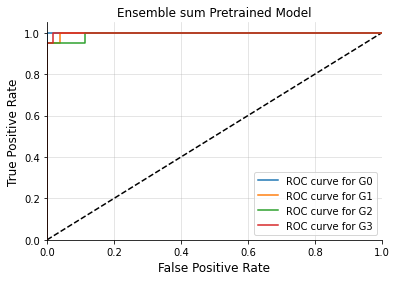

In [ ]:
plot_multiclass_roc( summed_all_nor, pd.get_dummies(y_true), n_classes=len(folders),class_label=class_label,fig_title='Ensemble sum Pretrained Model', figsize=(8, 6))

In [ ]:
summed_all_nor[1,:]

array([0.84454197, 0.05185907, 0.06014182, 0.0434572 ], dtype=float32)

In [ ]:
summed_all[1,:]/4

array([0.84454197, 0.05185907, 0.06014182, 0.0434572 ], dtype=float32)

In [ ]:
#type(y_true)
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

In [ ]:
#pd.get_dummies(m[:,0])
y_pred_VGG16

1.0 G0
1.0 G1
1.0 G2
1.0 G3


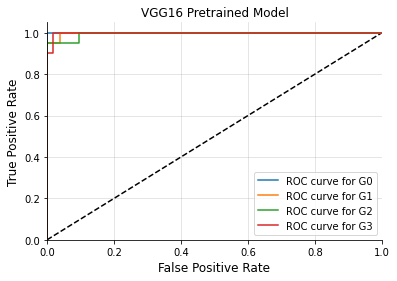

In [ ]:
# to print roc curve for each base and for ensemble 
class_label=list(train_generator.class_indices.keys())
y_pred_DenseNet121_class.shape
y_pred_DenseNet121_class.ndim
m=np.empty([73, 0], dtype=int)
m=np.column_stack((m, y_pred_DenseNet121))
plot_multiclass_roc( m[:,], pd.get_dummies(y_true), n_classes=len(folders),class_label=class_label,fig_title='VGG16 Pretrained Model', figsize=(8, 6))


In [ ]:
y_pred_DenseNet121.shape

(73, 4)

In [ ]:
for i in range(n_classes):
        y_test.iloc[:, i], y_pred[:, i])

In [ ]:
type(plot_multiclass_roc)

In [ ]:
# indvidual results 
print([np.average(run_DenseNet121_acc),np.average(run_DenseNet121_sensitivity),np.average(run_DenseNet121_specificity)])
print([np.average(run_MobileNetV2_acc),np.average(run_InceptionV3_sensitivity),np.average(run_MobileNetV2_specificity)])
print([np.average(run_InceptionV3_acc),np.average(run_majority_sensitivity),np.average(run_InceptionV3_specificity)])
print([np.average(run_VGG16_acc),np.average(run_VGG16_sensitivity),np.average(run_VGG16_specificity)])

    

[0.9726027397260274, 0.975, 1.0]
[0.9452054794520548, 0.925, 1.0]
[0.9178082191780822, 0.95, 1.0]
[0.5205479452054794, 0.5423076923076924, 0.9090909090909091]


In [ ]:
# indvidual std. 
print([np.std(run_DenseNet121_acc),np.std(run_DenseNet121_sensitivity),np.std(run_DenseNet121_specificity)])
print([np.std(run_MobileNetV2_acc),np.std(run_InceptionV3_sensitivity),np.std(run_MobileNetV2_specificity)])
print([np.std(run_InceptionV3_acc),np.std(run_majority_sensitivity),np.std(run_InceptionV3_specificity)])
print([np.std(run_VGG16_acc),np.std(run_VGG16_sensitivity),np.std(run_VGG16_specificity)])

     

In [ ]:
run_DenseNet121_acc
#results_DenseNet121

# New Section

In [ ]:
results_DenseNet121

In [ ]:
print([np.average(run_sum_acc),np.average(run_sum_sensitivity),np.average(run_sum_specificity)])
print([np.average(run_prod_acc),np.average(run_prod_sensitivity),np.average(run_prod_specificity)])
print([np.average(run_majority_acc),np.average(run_majority_sensitivity),np.average(run_majority_specificity)])

In [ ]:
[run_prod_acc,run_prod_sensitivity ,run_prod_specificity ]
run_sum_acc

In [ ]:
run_prod_sensitivity

italicized text# New Section

In [ ]:
print([np.std(run_sum_acc),np.std(run_sum_sensitivity),np.std(run_sum_specificity)])
print([np.std(run_prod_acc),np.std(run_prod_sensitivity),np.std(run_prod_specificity)])
print([np.std(run_majority_acc),np.std(run_majority_sensitivity),np.std(run_majority_specificity)])

In [ ]:
     np.average(run_prod_acc)

In [ ]:
#run_DenseNet121_acc
run_InceptionV3_acc

In [ ]:
import pickle

a = 3; b = [11,223,435];
pickle.dump([a,b], open("trial.p", "wb"))

c,d = pickle.load(open("trial.p","rb"))

print(c,d) ## To verify

In [ ]:
np.save('run_DenseNet121_acc',run_DenseNet121_acc)
np.save('run_MobileNetV2_acc',run_MobileNetV2_acc)
np.save('run_InceptionV3_acc',run_InceptionV3_acc)
np.save('run_VGG16_acc',run_VGG16_acc)

np.save('run_majority_acc',run_majority_acc)
np.save('run_sum_acc',run_sum_acc)
np.save('run_prod_acc',run_prod_acc)

''' ========='''
np.save('run_DenseNet121_sensitivity',run_DenseNet121_sensitivity)
np.save('run_MobileNetV2_sensitivity',run_MobileNetV2_sensitivity)
np.save('run_InceptionV3_sensitivity',run_InceptionV3_sensitivity)
np.save('run_VGG16_sensitivity',run_VGG16_sensitivity)

np.save('run_majority_sensitivity',run_majority_sensitivity)
np.save('run_sum_sensitivity',run_sum_sensitivity)
np.save('run_prod_sensitivity',run_prod_sensitivity)


''' ========='''
np.save('run_DenseNet121_specificity',run_DenseNet121_specificity)
np.save('run_MobileNetV2_specificity',run_MobileNetV2_specificity)
np.save('run_InceptionV3_specificity',run_InceptionV3_specificity)
np.save('run_VGG16_specificity',run_VGG16_specificity)

np.save('run_majority_specificity',run_majority_specificity)
np.save('run_sum_specificity',run_sum_specificity)
np.save('run_prod_specificity',run_prod_specificity)
#%%




In [ ]:
!zip -r /content/saved_model_h5.zip /content/saved_model_h5
#https://stackoverflow.com/questions/50453428/how-do-i-download-multiple-files-or-an-entire-folder-from-google-colab
#Than I have downloded that zip file:
#!zip -r "/content/drive/My Drive/Getting started.zip"
# from google.colab import files?
#files.download("/content/models_10runs.zip")""

In [ ]:
#!zip -r "/content/drive/My Drive/models_10runs.zip"

In [ ]:
#files.download("/content/models_10runs.zip")

In [ ]:
# to delete a folder 1323123
#''' !rm -rf saved_model_old''' #####

In [ ]:
!ls -al

In [ ]:
#1123123123123122